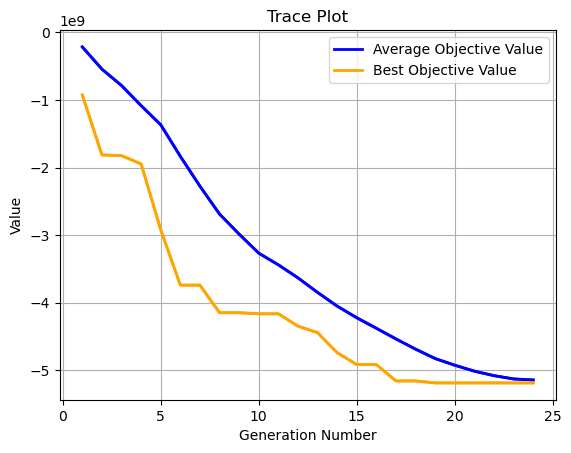

Execution time: 0.6662850379943848 s
Evaluation number: 2400
The best objective value is: -5185765400.0
The best variables are: 
8	8	8	8	8	0	0	1	1	1	2	1	1	1	0	2	2	4	6	8	4	


In [9]:
import numpy as np
import geatpy as ea
import torch 
import sys
sys.path.append("..")
from predictor.mlp import FeedforwardNet
sys.path.append("../encode+decode/")
from decode import decode,decode_lite
from flops_params import flops_params
model_path = "/home/qhy/Reserach/AICAS/predictor/MLP/loss-mse-input_dims-21-num_layers-4-layer_width-40_30_20_10-lr-0.1-regular-0.1-r-train-0.9238-r-test-0.9443.pth"
model_param = torch.load(model_path)
hyperparams = model_param["hyperparams"]
predictor = FeedforwardNet(hyperparams["input_dims"],hyperparams["num_layers"],hyperparams["layer_width"],1,'relu')
predictor.load_state_dict(model_param['model'])

class EA(ea.Problem):  # 继承Problem父类
    def __init__(self,model):
        name = 'EA'  # 初始化name（函数名称，可以随意设置）
        M = 1  # 优化目标个数
        maxormins = [1] *M  # 初始化maxormins（目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标）
        Dim = M  # 初始化Dim（决策变量维数）
        varTypes = [1] * 21  # 初始化varTypes（决策变量的类型，0：实数；1：整数）
        lb = [1]*5+[0]*5+[0]*6+[1]*5  # 决策变量下界
        ub = [8]*5+[1]*5+[2]*6+[2,4,6,8,4]  # 决策变量上界
        lbin = [1]*21  # 决策变量下边界（0表示不包含该变量的下边界，1表示包含）
        ubin = [1]*21  # 决策变量上边界（0表示不包含该变量的上边界，1表示包含）
        self.predictor = model
        # 调用父类构造方法完成实例化
        ea.Problem.__init__(self, name, M, maxormins, Dim, varTypes, lb, ub, lbin, ubin)

    def aimFunc(self, pop):  # 目标函数
        Vars = pop.Phen  # 获取决策变量矩阵，它等于种群的表现型矩阵Phen
        Vars = torch.tensor(Vars)
        accuracy = []
        flops = []
        params = []
        
        for i in range(Vars.shape[0]):
            acc = self.predictor(Vars[i]*1.0).detach().numpy()*-1
            # print("=*"*10)
            # print(Vars[i].detach().cpu().numpy().shape)
            # dir,f,p = decode_lite((Vars[i].detach().cpu().numpy()),"cifar10")
            # print(dir)
            f,p = flops_params(Vars[i].detach().cpu().numpy())
            accuracy.append(acc*f*p) 
            
            # flops.append(f)
            # params.append(p)
            # print(f,p)
        # flops = np.expand_dims(np.array(flops), axis=1)
        # params = np.expand_dims(np.array(params), axis=1)
        accuracy = np.array(accuracy)
        # print((flops).shape)
        # print((params).shape)    
        # print((accuracy).shape)    
        # f2 = (Vars - 2) ** 2
        pop.ObjV = np.hstack([accuracy])  # 计算目标函数值矩阵，赋值给种群对象的ObjV属性
        # pop.CV = -Vars ** 2 + 2.5 * Vars - 1.5  # 构建违反约束程度矩阵，赋值给种群对象的CV属性

# 实例化问题对象
problem = EA(predictor)
# 构建算法
algorithm = ea.soea_SEGA_templet(problem,
                                ea.Population(Encoding='RI', NIND=100),
                                MAXGEN=500,  # 最大进化代数。
                                logTras=1,  # 表示每隔多少代记录一次日志信息，0表示不记录。
                                trappedValue=1e-6,  # 单目标优化陷入停滞的判断阈值。
                                maxTrappedCount=10)  # 进化停滞计数器最大上限值。
# algorithm = ea.moea_NSGA2_templet(problem,
#                                 ea.Population(Encoding='RI', NIND=100),
#                                 MAXGEN=500,  # 最大进化代数。
#                                 logTras=1,  # 表示每隔多少代记录一次日志信息，0表示不记录。
#                                 trappedValue=1e-6,  # 单目标优化陷入停滞的判断阈值。
#                                 maxTrappedCount=10)  # 进化停滞计数器最大上限值。

# 求解
res = ea.optimize(algorithm, seed=1, verbose=False, drawing=1, outputMsg=True, drawLog=False, saveFlag=False, dirName='result')



In [1]:
800+1200*0.8

1760.0

In [ ]:
#acc+flops
[0.125, 0.125, 1.0, 1.0, 0.125]
[2, 1, 1, 1, 1]
#3
[1.0, 0.125, 1.0, 1.0, 0.125]
[2, 2, 4, 6, 8]
#acc+params
[1.0, 0.125, 1.0, 1.0, 0.125]
[2, 2, 4, 6, 8]

In [10]:
import sys
sys.path.append("../encode+decode/")
from decode import decode
con_map = {0:"acc+flops+params",1:"acc",2:"acc+flops",3:"acc+params",4:"flops",5:"params",6:"param+flops"}
decode(list(res['Vars'][0]),"cifar10",n=5,save=True,constrain = con_map[0])  
        

[1.0, 1.0, 1.0, 1.0, 1.0]
[2, 2, 4, 6, 8]
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_avgpool() for <class 'torch.nn.modules.pooling.AvgPool2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
|5|2-2-4-6-8|1.0-1.0-1.0-1.0-1.0|repvgg-repvgg-vgg-vgg-vgg|False-False-True-True-True|None-None-avgpool-avgpool-avgpool-maxpool|cifar10|214.41|21.59||acc+flops+params||


In [28]:
list(res['Vars'][0]/np.array([8]*5+[1]*16))

[1.0,
 0.875,
 1.0,
 1.0,
 0.125,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 4.0,
 6.0,
 1.0,
 4.0]